In [43]:
"""
Title: Visualizing what convnets learn
Author: [fchollet](https://twitter.com/fchollet)
Date created: 2020/05/29
Last modified: 2020/05/29
Description: Displaying the visual patterns that convnet filters respond to.
"""
"""
## Introduction
In this example, we look into what sort of visual patterns image classification models
learn. We'll be using the `ResNet50V2` model, trained on the ImageNet dataset.
Our process is simple: we will create input images that maximize the activation of
specific filters in a target layer (picked somewhere in the middle of the model: layer
`conv3_block4_out`). Such images represent a visualization of the
pattern that the filter responds to.
"""

"""
## Setup
"""

import numpy as np
#import tensorflow as tf
#from tensorflow import keras
import tensorflow.keras

In [44]:
#Load function to get f1-score metric for Keras
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [45]:
# The dimensions of our input image
img_width = 180
img_height = 180

# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
layer_name = "conv3_block4_out"

"""
## Build a feature extraction model
"""

# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = keras.applications.ResNet50V2(weights="imagenet", include_top=False)
#model.summary()
# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [46]:
print(model.inputs)
print(layer.output)
feature_extractor

[<tf.Tensor 'input_11:0' shape=(None, None, None, 3) dtype=float32>]
Tensor("conv3_block4_out_10/Identity:0", shape=(None, None, None, 512), dtype=float32)


In [47]:
from tensorflow.keras.models import load_model

layer_name = 'block5_conv3' 

#load the model
model = load_model('transfer_model_20000n.tf', custom_objects={'f1_m': f1_m, 'precision_m':precision_m, 'recall_m':recall_m})
#model.summary()

# Set up a model that returns the activation values for our target layer
layer = model.get_layer('vgg16').get_layer(name=layer_name)

In [48]:
print(model.inputs)
print(layer.output)

[<tf.Tensor 'batch_normalization_1_input_8:0' shape=(None, 64, 64, 3) dtype=float32>]
Tensor("block5_conv3_8/Identity:0", shape=(None, 4, 4, 512), dtype=float32)


In [49]:
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_1_9:0", shape=(None, 64, 64, 3), dtype=float32) at layer "input_1". The following previous layers were accessed without issue: []

In [50]:
layer_name = 'conv2d_7' 

#load the model
model = load_model('baseline_model_20000n.h5', custom_objects={'f1_m': f1_m, 'precision_m':precision_m, 'recall_m':recall_m})
#model.summary()

# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [51]:
"""
## Set up the gradient ascent process
The "loss" we will maximize is simply the mean of the activation of a specific filter in
our target layer. To avoid border effects, we exclude border pixels.
"""


def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)


"""
Our gradient ascent function simply computes the gradients of the loss above
with regard to the input image, and update the update image so as to move it
towards a state that will activate the target filter more strongly.
"""


@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


"""
## Set up the end-to-end filter visualization loop
Our process is as follow:
- Start from a random image that is close to "all gray" (i.e. visually netural)
- Repeatedly apply the gradient ascent step function defined above
- Convert the resulting input image back to a displayable form, by normalizing it,
center-cropping it, and restricting it to the [0, 255] range.
"""


def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

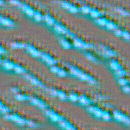

In [52]:
"""
Let's try it out with filter 0 in the target layer:
"""

from IPython.display import Image, display

loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("0.png", img)

"""
This is what an input that maximizes the response of filter 0 in the target layer would
look like:
"""

display(Image("0.png"))

In [ ]:
"""
## Visualize the first 64 filters in the target layer
Now, let's make a 8x8 grid of the first 64 filters
in the target layer to get of feel for the range
of different visual patterns that the model has learned.
"""

# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))

"""
Image classification models see the world by decomposing their inputs over a "vector
basis" of texture filters such as these.
See also
[this old blog post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)
for analysis and interpretation.
"""